# Tugas Eksplorasi ResNet Kelompok 13 NGASAL
Mata Kuliah: Pembelajaran Mendalam (IF25-40401) RA 
Program Studi Teknik Informatika – Institut Teknologi Sumatera
### Nama Anggota Kelompok:
- Bayu Prameswara Haris - 122140219
- Jason Surya Padantya - 122140237
- Abu Bakar Siddiq Siregar - 122140164


## 1. Instalasi Dependensi

In [3]:
import os, math, json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import classification_report

## 2. Konfigurasi dan Data Loader

In [4]:
class FoodDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {
            "gado_gado": 0,
            "bakso": 1,
            "rendang": 2,
            "nasi_goreng": 3,
            "soto_ayam": 4
        }
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.label_map[self.data.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label

# === SAMAKAN transform, batch_size, split, epoch, optimizer, LR DENGAN TAHAP 1 ===
IMG_ROOT = "train"  # <-- GANTI sesuai dataset kamu
CSV_PATH = "train.csv"       # nama file CSV Tahap 1

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = FoodDataset(csv_file=CSV_PATH, root_dir=IMG_ROOT, transform=transform)

# Split yang sama dengan Tahap 1 (mis. 80:20). 
# Jika Tahap 1 pakai seed tertentu, set di sini juga agar split identik.
generator = torch.Generator().manual_seed(42)  # GANTI jika Tahap 1 beda seed
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

BATCH_SIZE = 32   # <-- SAMAKAN
EPOCHS = 10       # <-- SAMAKAN
LR = 1e-3         # <-- SAMAKAN
OPTIM = "adam"    # <-- SAMAKAN ('adam' atau 'sgd' dsb.)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## 3. Modiikasi Model

In [9]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        # Asumsi conv3x3 sudah didefinisikan
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # stages: [3,4,6,3] untuk ResNet-34
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)

        # He init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:   # ✅ tambahkan pengecekan
                    nn.init.constant_(m.bias, 0)

        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        # jika dimensi berubah (stride!=1 atau channel berubah), siapkan downsample
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes*block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x); x = self.bn1(x); x = self.relu(x); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


## 4. Builder

In [10]:
def resnet34(num_classes=5):
    return ResNet(BasicBlock, [3,4,6,3], num_classes=num_classes)

def resnet34_se(num_classes=5):
    return ResNet(BasicBlockSE, [3,4,6,3], num_classes=num_classes)

## 5. Training Utilities

In [11]:
# =====================================================
# Training utilities 
# =====================================================
criterion = nn.CrossEntropyLoss()

def run_epoch(model, loader, train=True, optimizer=None): # <-- Tambah parameter optimizer
    if train:
        model.train()
        if optimizer is None: # Cek jika train=True tapi optimizer tidak disediakan
             raise ValueError("Optimizer harus disediakan saat train=True.") 
    else:
        model.eval()
        
    running_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            if train:
                optimizer.zero_grad() # <-- Gunakan parameter lokal
                loss.backward()
                optimizer.step()     # <-- Gunakan parameter lokal
                
            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()
            
    loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    return loss, acc


In [13]:
from sklearn.metrics import classification_report 

def get_classification_report(model, loader, device):
    """Menghasilkan classification report pada validation/test set."""
    model.eval()
    all_preds = []
    all_labels = []
    # Label Map harus sesuai dengan urutan index di DataLoader Anda (0, 1, 2, 3, 4)
    target_names = ["gado_gado", "bakso", "rendang", "nasi_goreng", "soto_ayam"] 
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return classification_report(all_labels, all_preds, target_names=target_names)

## 6. Training Data dan Save

In [14]:
# =====================================================
# Training loop 
# =====================================================

# 1. Inisialisasi Model yang Akan Dilatih
models_to_train = {
    "resnet34": resnet34().to(device),      
    "resnet34_se": resnet34_se().to(device) 
}

histories = {} 

# 2. Sequential Training Loop
for name, model in models_to_train.items():
    print(f"\n{'='*10} Training {name} {'='*10}")
    
    # Inisialisasi Optimizer DI SINI (Wajib direset per model!)
    if OPTIM.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=LR)
    elif OPTIM.lower() == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, nesterov=False)
    else:
        print(f"[ERROR] Optimizer {OPTIM} tidak valid. Lewati {name}.")
        continue
        
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "report": ""}

    # Training Loop per Epoch
    for epoch in range(EPOCHS):
        # Panggil run_epoch DENGAN optimizer sebagai argumen (WAJIB)
        tr_loss, tr_acc = run_epoch(model, train_loader, train=True, optimizer=optimizer) 
        va_loss, va_acc = run_epoch(model, val_loader, train=False, optimizer=optimizer)

        # Simpan metrik
        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc); history["val_acc"].append(va_acc)
        
        # Log Output Epoch
        print(f"Epoch {epoch+1}/{EPOCHS} | Train {tr_acc:.2f}% | Val {va_acc:.2f}%")
        
    print(f"🎉 Training {name} selesai!")
    
    # --- Classification Report ---
    report = get_classification_report(model, val_loader, device) 
    print(f"\n=== Classification Report for {name} ===\n{report}")
    
    # --- Saving ---
    history["report"] = report
    histories[name] = history 
    torch.save(model.state_dict(), f"{name}.pth")
    np.savez(f"{name}_history.npz", **history)

print("\nSemua pelatihan dan evaluasi selesai!")


========== Training resnet34 ==========
Epoch 1/10 | Train 43.12% | Val 46.40%
Epoch 1/10 | Train 43.12% | Val 46.40%
Epoch 2/10 | Train 58.13% | Val 40.09%
Epoch 2/10 | Train 58.13% | Val 40.09%
Epoch 3/10 | Train 63.54% | Val 42.79%
Epoch 3/10 | Train 63.54% | Val 42.79%
Epoch 4/10 | Train 63.77% | Val 57.21%
Epoch 4/10 | Train 63.77% | Val 57.21%
Epoch 5/10 | Train 68.17% | Val 63.96%
Epoch 5/10 | Train 68.17% | Val 63.96%
Epoch 6/10 | Train 71.67% | Val 33.33%
Epoch 6/10 | Train 71.67% | Val 33.33%
Epoch 7/10 | Train 70.65% | Val 67.57%
Epoch 7/10 | Train 70.65% | Val 67.57%
Epoch 8/10 | Train 74.60% | Val 70.27%
Epoch 8/10 | Train 74.60% | Val 70.27%
Epoch 9/10 | Train 75.28% | Val 54.50%
Epoch 9/10 | Train 75.28% | Val 54.50%
Epoch 10/10 | Train 76.64% | Val 61.26%
🎉 Training resnet34 selesai!
Epoch 10/10 | Train 76.64% | Val 61.26%
🎉 Training resnet34 selesai!

=== Classification Report for resnet34 ===
              precision    recall  f1-score   support

   gado_gado       0

c:\Users\Asus\miniconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Asus\miniconda3\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\Asus\miniconda3\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10 | Train 45.60% | Val 25.23%
Epoch 2/10 | Train 59.82% | Val 53.60%
Epoch 2/10 | Train 59.82% | Val 53.60%
Epoch 3/10 | Train 67.04% | Val 52.70%
Epoch 3/10 | Train 67.04% | Val 52.70%
Epoch 4/10 | Train 68.62% | Val 45.05%
Epoch 4/10 | Train 68.62% | Val 45.05%
Epoch 5/10 | Train 72.12% | Val 60.81%
Epoch 5/10 | Train 72.12% | Val 60.81%
Epoch 6/10 | Train 73.59% | Val 59.01%
Epoch 6/10 | Train 73.59% | Val 59.01%
Epoch 7/10 | Train 76.07% | Val 64.86%
Epoch 7/10 | Train 76.07% | Val 64.86%
Epoch 8/10 | Train 78.33% | Val 64.86%
Epoch 8/10 | Train 78.33% | Val 64.86%
Epoch 9/10 | Train 78.10% | Val 70.27%
Epoch 9/10 | Train 78.10% | Val 70.27%
Epoch 10/10 | Train 81.04% | Val 68.47%
🎉 Training resnet34_se selesai!
Epoch 10/10 | Train 81.04% | Val 68.47%
🎉 Training resnet34_se selesai!

=== Classification Report for resnet34_se ===
              precision    recall  f1-score   support

   gado_gado       0.70      0.30      0.42        46
       bakso       0.42      1.00    

### 6.1 Load History Data Training

In [21]:
def load_history(name):
    """Memuat history pelatihan dari file NPZ yang disimpan menggunakan **history."""
    try:
        # Memuat file NPZ
        h = np.load(f"{name}_history.npz", allow_pickle=True)
        
        # Karena 'meta' tidak disimpan, kita tidak bisa memuatnya. 
        # Kita hanya memuat key yang tersimpan: train_loss, val_loss, train_acc, val_acc, dan report.
        
        # h['report'] adalah array numpy, .item() mengambil string di dalamnya
        report_content = h['report'].item() if 'report' in h else "N/A"
        
        return {
            "train_loss": h["train_loss"].tolist(),
            "val_loss": h["val_loss"].tolist(),
            "train_acc": h["train_acc"].tolist(),
            "val_acc": h["val_acc"].tolist(),
            "report": report_content,
            "config": {} # Konfigurasi tidak disimpan, jadi dikosongkan saja
        }
    except FileNotFoundError:
        print(f"Error: File {name}_history.npz tidak ditemukan. Pastikan nama file benar.")
        return None

### 6.2 Memuat Data History

In [22]:
# Muat data dari file yang sudah disimpan
histories = {
    # Pastikan nama model sesuai dengan yang Anda latih
    "ResNet34 (Baseline)": load_history("resnet34"),
    "ResNet34-SE (Explorasi)": load_history("resnet34_se"),
}

print("History kedua model berhasil dimuat. Siap untuk visualisasi!")

History kedua model berhasil dimuat. Siap untuk visualisasi!


## 7. Menampilkan Plot dan Hasil Evaluasi

Total model yang berhasil dimuat: 2


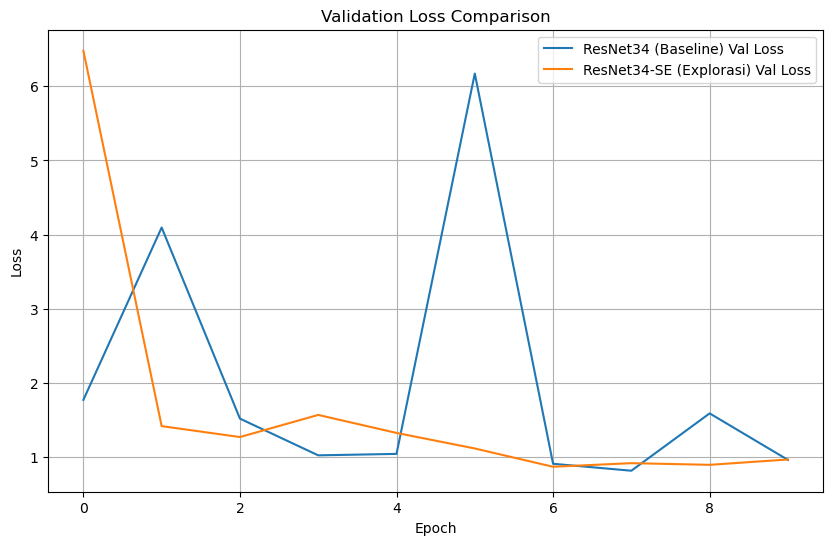

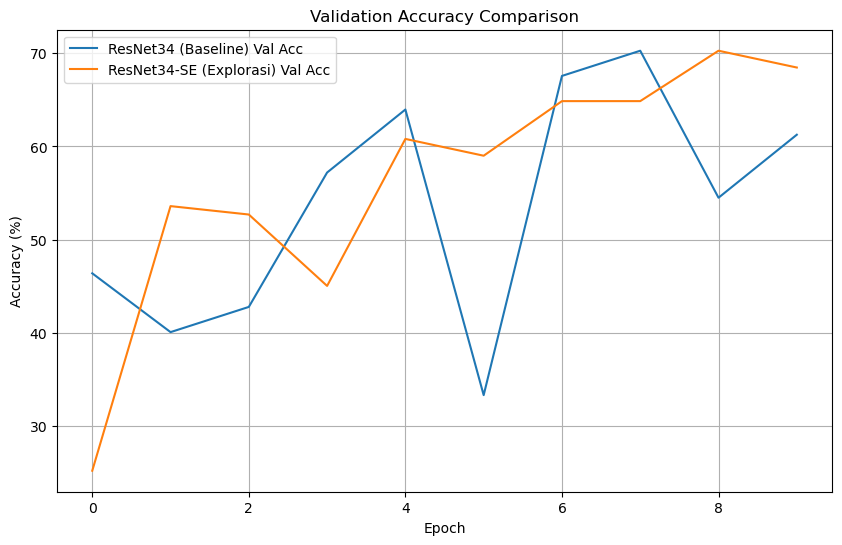


=== Perbandingan Kinerja (Epoch Terakhir) ===
                  Model Train Loss Val Loss Train Acc % Val Acc %
    ResNet34 (Baseline)     0.6626   0.9584       76.64     61.26
ResNet34-SE (Explorasi)     0.5419   0.9636       81.04     68.47


In [23]:
# --- Nama File Anda ---
BASELINE_FILE = "resnet34_history.npz"
SE_FILE = "resnet34_se_history.npz"

# --- Fungsi Utilitas ---

def safe_last(h_dict, key):
    """Mengambil nilai terakhir dari list dalam dictionary, aman dari error."""
    lst = h_dict.get(key, []) 
    return lst[-1] if lst else np.nan

def load_npz_history(file_path):
    """Helper function untuk memuat history dari file .npz yang sudah tersimpan."""
    if os.path.exists(file_path):
        data = np.load(file_path, allow_pickle=True)
        # Muat hanya key yang kita butuhkan, sesuai dengan struktur saving Anda (**history)
        return {k: v.tolist() for k, v in data.items() if k in ["train_loss", "val_loss", "train_acc", "val_acc"]}
    print(f"[WARNING] File {file_path} tidak ditemukan. Model ini dilewati.")
    return None

# --- Pengumpulan History (Hanya Dua Model Anda) ---
all_histories = {}
models_to_plot = []

# Muat ResNet34 (Baseline)
hist_base = load_npz_history(BASELINE_FILE)
if hist_base:
    all_histories["ResNet34 (Baseline)"] = hist_base
    models_to_plot.append("ResNet34 (Baseline)")

# Muat ResNet34-SE (Eksplorasi)
hist_se = load_npz_history(SE_FILE)
if hist_se:
    all_histories["ResNet34-SE (Explorasi)"] = hist_se
    models_to_plot.append("ResNet34-SE (Explorasi)")

print(f"Total model yang berhasil dimuat: {len(all_histories)}")

# Jika tidak ada model yang dimuat, hentikan
if not all_histories:
    print("Tidak ada file history yang ditemukan. Pastikan nama file .npz sudah benar.")
# Jika ada, lanjutkan ke plotting dan tabel
else:
    # --- Plotting Overlay (Loss dan Accuracy) ---
    
    # Plot Validation Loss
    plt.figure(figsize=(10, 6))
    for name, hist in all_histories.items():
        plt.plot(hist["val_loss"], label=f"{name} Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Validation Loss Comparison"); plt.legend(); plt.grid(True)
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    for name, hist in all_histories.items():
        plt.plot(hist["val_acc"], label=f"{name} Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Validation Accuracy Comparison"); plt.legend(); plt.grid(True)
    plt.show()

    # --- Tabel Ringkas (Epoch Terakhir) ---
    summary_data = {
        "Model": [],
        "Train Loss": [],
        "Val Loss": [],
        "Train Acc %": [],
        "Val Acc %": []
    }

    # Urutan tampilan
    display_order = ["ResNet34 (Baseline)", "ResNet34-SE (Explorasi)"] 

    for name in display_order:
        if name in all_histories:
            hist = all_histories[name]
            summary_data["Model"].append(name)
            summary_data["Train Loss"].append(safe_last(hist, "train_loss"))
            summary_data["Val Loss"].append(safe_last(hist, "val_loss"))
            summary_data["Train Acc %"].append(safe_last(hist, "train_acc"))
            summary_data["Val Acc %"].append(safe_last(hist, "val_acc"))

    df = pd.DataFrame(summary_data)

    # Formatting
    df = df.fillna('N/A')
    df['Train Loss'] = df['Train Loss'].map(lambda x: f'{float(x):.4f}' if x != 'N/A' else x)
    df['Val Loss'] = df['Val Loss'].map(lambda x: f'{float(x):.4f}' if x != 'N/A' else x)
    df['Train Acc %'] = df['Train Acc %'].map(lambda x: f'{float(x):.2f}' if x != 'N/A' else x)
    df['Val Acc %'] = df['Val Acc %'].map(lambda x: f'{float(x):.2f}' if x != 'N/A' else x)

    print("\n=== Perbandingan Kinerja (Epoch Terakhir) ===")
    print(df.to_string(index=False))

In [24]:
for name, hist in histories.items():
    report = hist["report"]  # ini string ASCII
    print(f"\n=== Evaluasi Detail: {name} ===")
    print(report)



=== Evaluasi Detail: ResNet34 (Baseline) ===
              precision    recall  f1-score   support

   gado_gado       0.44      0.46      0.45        46
       bakso       0.77      0.44      0.56        45
     rendang       0.89      0.87      0.88        39
 nasi_goreng       1.00      0.34      0.51        41
   soto_ayam       0.49      0.92      0.64        51

    accuracy                           0.61       222
   macro avg       0.72      0.61      0.61       222
weighted avg       0.70      0.61      0.60       222


=== Evaluasi Detail: ResNet34-SE (Explorasi) ===
              precision    recall  f1-score   support

   gado_gado       0.70      0.30      0.42        46
       bakso       0.42      1.00      0.60        45
     rendang       1.00      0.79      0.89        39
 nasi_goreng       1.00      0.63      0.78        41
   soto_ayam       0.92      0.71      0.80        51

    accuracy                           0.68       222
   macro avg       0.81      0.69  